In [9]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from common import fetch_data, get_backtest_result, get_hodl_result, max_drawdown, sharpe_ratio, save_cache_data, load_cache_data

In [10]:
# Compute funding rate PNL with only one market
exchanges_market = {
    "binance": "BNBUSDT",
    "bitmex": "BNBUSD",
    "apollox": "BNBUSDT",
    "drift": "BNB-PERP",
}
benchmark_exchange = "binance"
market_name = exchanges_market[benchmark_exchange].replace('USDT', '')

# Initial variables
min_time = datetime.fromisoformat('2023-08-01').timestamp()
max_time = datetime.fromisoformat('2024-02-29').timestamp()

data_df_map = {}
results = {}

leverage = 1

# Read data from file
for exchange, market in exchanges_market.items():
    data_df = load_cache_data(exchange, market)
    data_df_map[exchange] = data_df

# calculate min max time
for exchange, market in exchanges_market.items():
    data_df = data_df_map[exchange]
    min_time = max(min_time, data_df["timestamp"].min())
    max_time = min(max_time, data_df["timestamp"].max())

# Calculate funding rate backtest result
for exchange, market in exchanges_market.items():
    data_df = data_df_map[exchange]
    data_df['datetime'] = data_df['datetime'].apply(lambda x: pd.to_datetime(x))

    data_df = data_df[
        (data_df["timestamp"] >= min_time) & (data_df["timestamp"] <= max_time)
    ]

    data_df = data_df.sort_values(by='datetime', ascending=True)
    data_df = data_df.reset_index(drop=True)

    result_df = get_backtest_result(data_df, leverage)
    results[exchange] = result_df

hodl_df = get_hodl_result(results[benchmark_exchange])

# Results are store in 'results' and 'hodl_df' variables

{'BNBUSDT binance': 0       0.00000
1      -0.00012
2      -0.00012
3      -0.00012
4      -0.00012
         ...   
5083        NaN
5084        NaN
5085        NaN
5086        NaN
5087        NaN
Name: final_pnl, Length: 5088, dtype: float64, 'BNBUSD bitmex': 0       0.000000
1      -0.000119
2      -0.000119
3      -0.000119
4      -0.000119
          ...   
4875         NaN
4876         NaN
4877         NaN
4878         NaN
4879         NaN
Name: final_pnl, Length: 4880, dtype: float64, 'BNBUSDT apollox': 0       0.000000
1      -0.000119
2      -0.000119
3      -0.000119
4      -0.000119
          ...   
5083         NaN
5084         NaN
5085         NaN
5086         NaN
5087         NaN
Name: final_pnl, Length: 5088, dtype: float64, 'BNB-PERP drift': 0       0.000000
1      -0.001043
2      -0.001137
3      -0.001224
4      -0.001316
          ...   
4972   -0.028243
4973   -0.028242
4974   -0.028239
4975   -0.028235
4976   -0.028235
Name: final_pnl, Length: 4977, dtype: float64, '

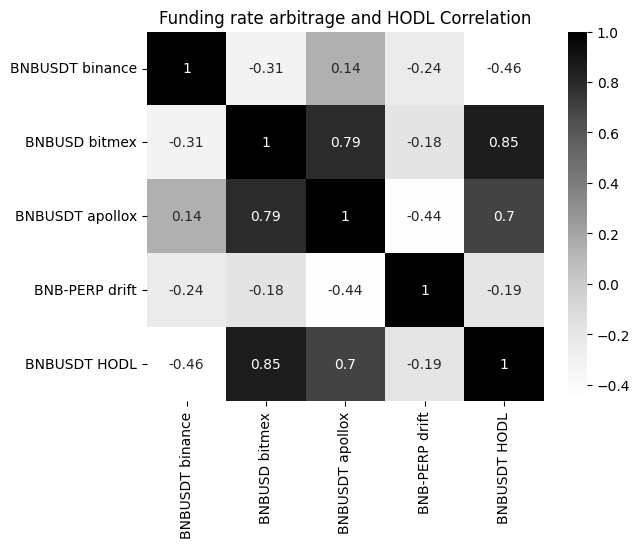

In [11]:
import seaborn as sns
import json

data = {}

# This is used for expanding data in exchanges with 8 hour period to 1 hour period
period = 8

for exchange, market in exchanges_market.items():
    data[f"{market} {exchange}"] = results[exchange]['final_pnl']
    if exchange != "drift":
        data[f"{market} {exchange}"] = data[f"{market} {exchange}"].repeat(period).shift(periods=-period + 1).reset_index(drop=True) / period

data[f"{exchanges_market[benchmark_exchange]} HODL"] = hodl_df['pnl'].repeat(period).shift(periods=-period + 1).reset_index(drop=True)
    
corr_df = pd.DataFrame(data)
corr_df.dropna(inplace=True)

correlation_matrix = corr_df.corr()

cmap = "Greys"
sns.heatmap(correlation_matrix, annot=True, cmap=cmap)
plt.title("Funding rate arbitrage and HODL Correlation")

plt.savefig(f'./images/corr_{market_name}.png', format='png', dpi=300, bbox_inches='tight')
correlation_matrix.to_csv(f'./output/corr_{market_name}.csv')
    
plt.show()